In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ruptures as rpt
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [2]:
def get_cpts(col: pd.Series) -> List[int]:
    signal = np.array(col)
    algo = rpt.Pelt(model="rbf").fit(signal)
    result = algo.predict(pen=len(signal) / 4)
    
    return result

def get_ROC(col_f1: pd.Series, col_f2: pd.Series) -> float:
    return abs((col_f1.iloc[-1,] - col_f2.iloc[0,]) / len(col_f1))

def get_tl(col_f1: pd.Series, col_f2: pd.Series) -> float:
    start = int(len(col_f1) / 5)
    end = len(col_f1) - start
    return abs(
        col_f1.iloc[start,] - col_f1.iloc[end,]
    ) + abs(
        col_f2.iloc[start,] - col_f2.iloc[end,]
    )

In [3]:
def make_df_cpts(folder: Path, d: int) -> pd.DataFrame:
    data = []
    for file in Path(f'divided/{folder}/csvs/').iterdir():
        df = pd.read_csv(file)
        f1 = get_cpts(df['f1'])
        f2 = get_cpts(df['f2'])
        data.append({
            'vowel': file.name.rsplit('_', d)[1],
            'cps_1': f1,
            'f1': len(f1),
            'cps_2': f2,
            'f2': len(f2),
            'length': len(df),
            'filename': file.name,
        })
    return pd.DataFrame(data)

In [4]:
def make_df_ROC(folder: Path, d: int) -> pd.DataFrame:
    data = []
    for file in Path(f'divided/{folder}/csvs/').iterdir():
        df = pd.read_csv(file)
        f1 = get_ROC(df['f1'], df['f2'])
        data.append({
            'vowel': file.name.rsplit('_', d)[1],
            'f1': f1
        })
    return pd.DataFrame(data)

In [5]:
def make_df_track_length(folder: Path, d: int) -> pd.DataFrame:
    data = []
    for file in Path(f'divided/{folder}/csvs/').iterdir():
        df = pd.read_csv(file)
        f1 = get_tl(df.f1, df.f2)
        data.append({
            'vowel': file.name.rsplit('_', d)[1],
            'f1': f1
        })
    return pd.DataFrame(data)

In [6]:
def draw_statistics(df: pd.DataFrame, mono: List[str], t: int = 0) -> None:
    
    gr = df.groupby('vowel')
    df[f'mean_1'] = gr['f1'].transform('mean')
    df['n'] = gr['vowel'].transform(len)
    
    sorted_df = df[
        ['vowel', 'mean_1', 'n']
    ].groupby('vowel').mean().sort_values('mean_1')
    
    print(sorted_df)
    
    if t == 0:
        t = np.mean(sorted_df.mean_1)
        print(f'Threshold is set to {t}')
    
    
    tp = df[(~df.vowel.isin(mono)) & (df.f1 > t)]
    tn = df[(df.vowel.isin(mono)) & (df.f1 <= t)]
    fp = df[(df.vowel.isin(mono)) & (df.f1 > t)]
    fn = df[(~df.vowel.isin(mono)) & (df.f1 <= t)]
    
    sns.heatmap([[len(tp), len(fp)],
             [len(fn), len(tn)]], annot=True, fmt='.0f',
            xticklabels = ['diphthong', 'monophthong'],
            yticklabels = ['diphthong', 'monophthong']
           )

    plt.xlabel('Real')
    plt.ylabel('Predicted');
    
    specificity = len(tn) / (len(tn) + len(fp))
    recall = len(tp) / (len(tp) + len(fn))

    balanced_accuracy = (specificity + recall) / 2

    print(balanced_accuracy, specificity, recall)

## Estonian

In [7]:
df = make_df_cpts('est_liisa', 3)

Overall number of monophthongs is 220
Overall number of diphthongs is 60
         mean_1     n
vowel                
iː     1.000000   6.0
æːː    1.000000   9.0
iːː    1.111111  18.0
æː     1.142857  14.0
æ      1.200000  60.0
eːː    1.291667  24.0
eː     1.333333  12.0
i      1.410256  39.0
e      1.421053  38.0
æe     1.666667   3.0
ie     1.833333  12.0
ea     1.911111  45.0
0.8075757575757576 0.7318181818181818 0.8833333333333333


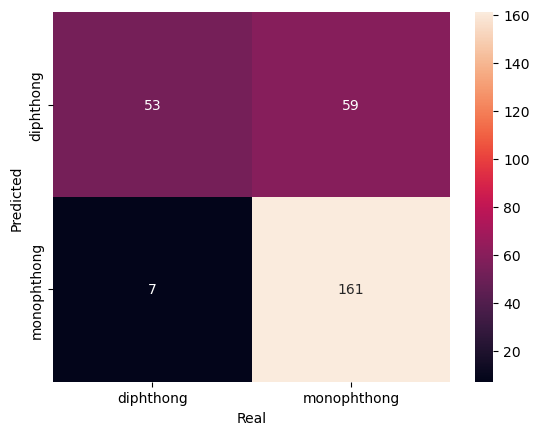

In [8]:
est_mono = ['i', 'iː', 'iːː', 'æ', 'æː', 'æːː', 'e', 'eː', 'eːː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(est_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(est_mono))}')

draw_statistics(df, est_mono, 1)

In [9]:
x = df[df.vowel.isin(est_mono)].f1
y = df[~df.vowel.isin(est_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(71.78977272727272,
 2.3938979770322937e-17,
 1,
 array([[132.,  36.],
        [ 88.,  24.]]))

In [10]:
df = make_df_ROC('est_liisa', 3)

          mean_1     n
vowel                 
æe      7.548440   3.0
æːː     9.374167   9.0
iːː    12.464835  18.0
iː     13.103577   6.0
ea     14.409862  45.0
æː     14.411100  14.0
eːː    14.675771  24.0
eː     14.785147  12.0
ie     16.576441  12.0
æ      29.192724  60.0
e      36.208570  38.0
i      58.525823  39.0
Threshold is set to 20.106371365613242
0.26515151515151514 0.41363636363636364 0.11666666666666667


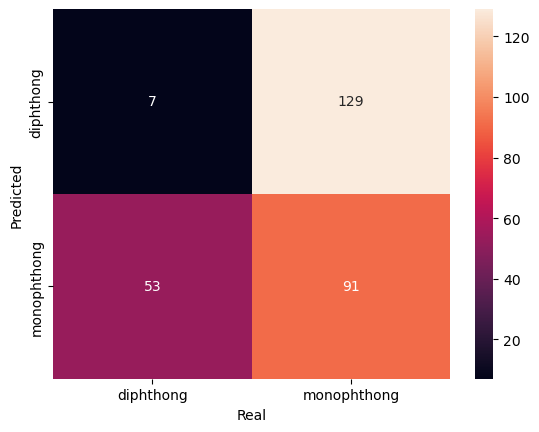

In [11]:
draw_statistics(df, est_mono)

In [12]:
df = make_df_track_length('est_liisa', 3)

            mean_1     n
vowel                   
eː      103.300000  12.0
æːː     119.166667   9.0
eːː     121.512500  24.0
iː      131.783333   6.0
iːː     137.955556  18.0
i       146.369231  39.0
æ       213.105000  60.0
æː      239.528571  14.0
e       260.447368  38.0
æe      303.500000   3.0
ie      658.075000  12.0
ea     1065.715556  45.0
Threshold is set to 291.7048984774971
0.8863636363636364 0.8227272727272728 0.95


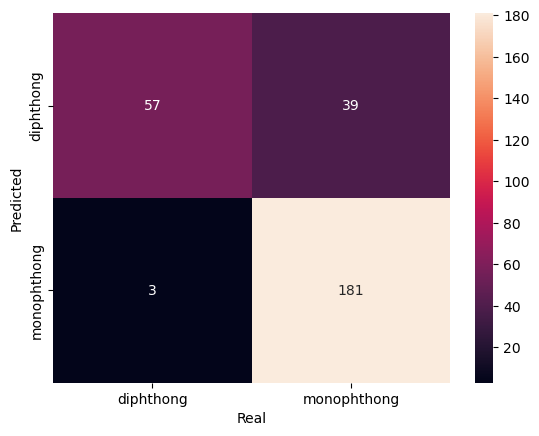

In [13]:
draw_statistics(df, est_mono)

In [14]:
df = make_df_cpts('est_vello', 3)

Overall number of monophthongs is 219
Overall number of diphthongs is 63
         mean_1     n
vowel                
iː     1.000000   6.0
æe     1.000000   3.0
æː     1.000000  12.0
æːː    1.000000   9.0
iːː    1.055556  18.0
eː     1.083333  12.0
e      1.111111  36.0
æ      1.157895  57.0
i      1.358974  39.0
eːː    1.400000  30.0
ie     1.708333  24.0
ea     1.750000  36.0
0.7555990432702762 0.8127853881278538 0.6984126984126984


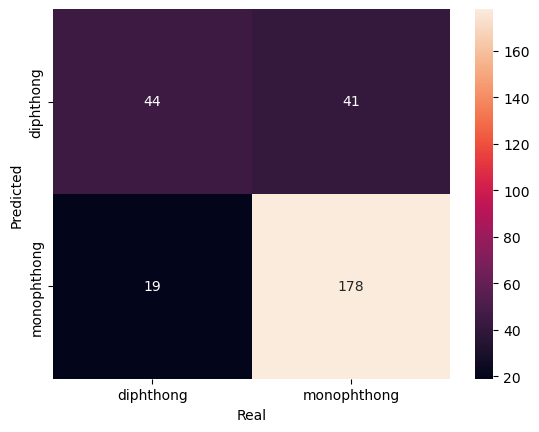

In [15]:
est_mono = ['i', 'iː', 'iːː', 'æ', 'æː', 'æːː', 'e', 'eː', 'eːː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(est_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(est_mono))}')

draw_statistics(df, est_mono, 1)

In [16]:
x = df[df.vowel.isin(est_mono)].f1
y = df[~df.vowel.isin(est_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(58.31586891901604,
 2.2323613566802255e-14,
 1,
 array([[152.9893617,  44.0106383],
        [ 66.0106383,  18.9893617]]))

In [17]:
df = make_df_ROC('est_vello', 3)

          mean_1     n
vowel                 
æe      4.971139   3.0
æːː     7.647776   9.0
æː      9.353437  12.0
eːː     9.454515  30.0
ea      9.850686  36.0
iːː    11.300739  18.0
eː     14.306956  12.0
ie     15.750694  24.0
iː     16.346863   6.0
æ      21.978753  57.0
e      25.322768  36.0
i      39.983629  39.0
Threshold is set to 15.522329609542567
0.3211567732115677 0.4200913242009132 0.2222222222222222


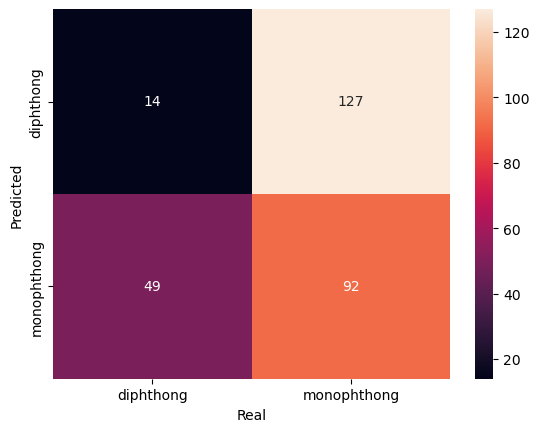

In [18]:
draw_statistics(df, est_mono)

In [19]:
df = make_df_track_length('est_vello', 3)

           mean_1     n
vowel                  
æːː     68.422222   9.0
æː      68.608333  12.0
iːː     71.888889  18.0
æ      109.096491  57.0
eː     112.458333  12.0
e      134.955556  36.0
eːː    139.566667  30.0
i      219.805128  39.0
iː     252.733333   6.0
æe     328.266667   3.0
ie     414.225000  24.0
ea     790.861111  36.0
Threshold is set to 225.90731087869244
0.9099804305283756 0.867579908675799 0.9523809523809523


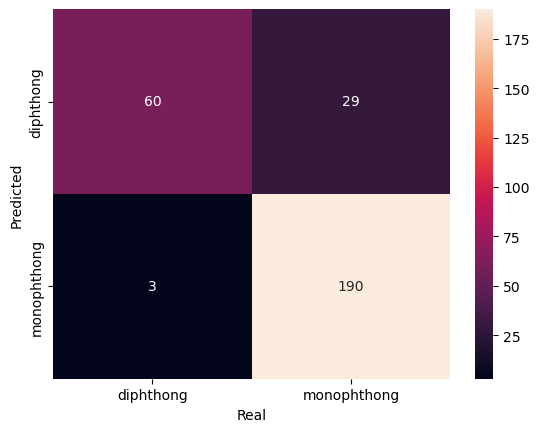

In [20]:
draw_statistics(df, est_mono)

## Lithuanian

In [21]:
df = make_df_cpts('lit', 3)

In [22]:
lit_mono = ['ˈɛː', 'ˈi', 'ˈiː', 'iː', 'i', 'ɛː', 'ˈeː', 'ɛ', 'eː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(lit_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(lit_mono))}')

Overall number of monophthongs is 531
Overall number of diphthongs is 162


In [23]:
x = df[df.vowel.isin(lit_mono)].f1
y = df[~df.vowel.isin(lit_mono)].f1


obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(72.29237179644984,
 1.8556330274806572e-17,
 1,
 array([[351.7012987, 107.2987013],
        [179.2987013,  54.7012987]]))

         mean_1      n
vowel                 
ɛː     1.083333   24.0
ɛ      1.095238   21.0
ˈɛː    1.158730   63.0
i      1.194030   67.0
iː     1.238095   63.0
ˈiː    1.250000  128.0
ˈi     1.269841   63.0
eː     1.416667   36.0
ˈeː    1.424242   66.0
iɛ     1.490196   51.0
ˈiɛ    1.675676  111.0
0.6824649508265328 0.7476459510357816 0.6172839506172839


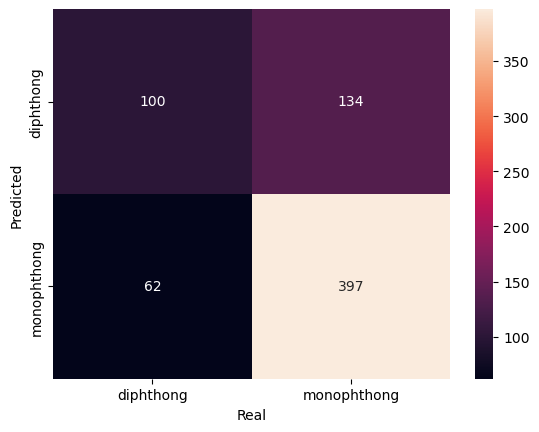

In [24]:
draw_statistics(df, lit_mono, 1)

In [25]:
df = make_df_ROC('lit', 3)

          mean_1      n
vowel                  
ˈɛː    12.932254   63.0
ˈeː    15.223105   66.0
ˈiɛ    16.250499  111.0
ɛː     23.447673   24.0
eː     23.688363   36.0
iɛ     23.821982   51.0
ˈiː    25.398455  128.0
ɛ      29.102885   21.0
iː     29.958339   63.0
ˈi     33.323679   63.0
i      38.456382   67.0
Threshold is set to 24.691237817375722
0.37549696589244613 0.5781544256120528 0.1728395061728395


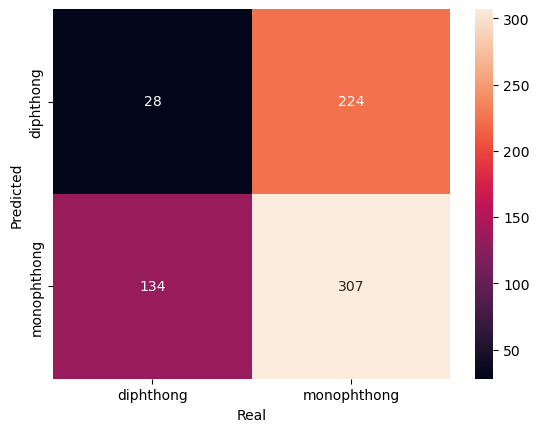

In [26]:
draw_statistics(df, lit_mono)

In [27]:
df = make_df_track_length('lit', 3)

            mean_1      n
vowel                    
ˈiː     200.650781  128.0
i       233.767164   67.0
ɛː      239.016667   24.0
ɛ       250.100000   21.0
ˈeː     263.350000   66.0
ˈi      287.687302   63.0
ˈɛː     349.692063   63.0
iː      359.223810   63.0
eː      364.002778   36.0
iɛ      844.698039   51.0
ˈiɛ    1068.737838  111.0
Threshold is set to 405.53876741184064
0.8671793262188743 0.8022598870056498 0.9320987654320988


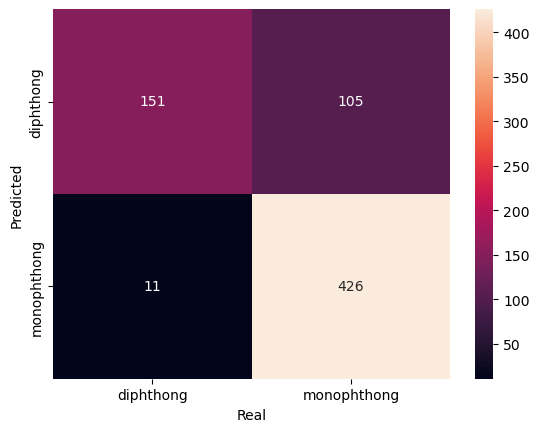

In [28]:
draw_statistics(df, lit_mono)

## Skolt Saami

In [29]:
df = make_df_cpts('skolt', 4)

In [30]:
skolt_mono = ['e', 'eː', 'õ', 'õː', 'â', 'âː', 'i', 'iː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(skolt_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(skolt_mono))}')

Overall number of monophthongs is 82
Overall number of diphthongs is 47


In [31]:
x = df[df.vowel.isin(skolt_mono)].f1
y = df[~df.vowel.isin(skolt_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(40.39427972951222,
 2.0754787118048087e-10,
 1,
 array([[54.03100775, 30.96899225],
        [27.96899225, 16.03100775]]))

         mean_1     n
vowel                
õː     1.000000   3.0
õ      1.038462  26.0
âː     1.083333  12.0
eː     1.142857  14.0
â      1.166667   6.0
e      1.285714  21.0
eä     1.656250  32.0
iä     1.666667   6.0
ie     1.833333   6.0
iõ     2.000000   3.0
0.7839906590555268 0.8658536585365854 0.7021276595744681


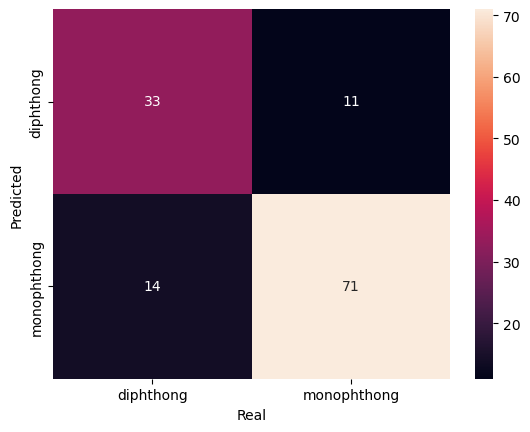

In [32]:
draw_statistics(df, skolt_mono, 1)

In [33]:
df = make_df_track_length('skolt', 4)

           mean_1     n
vowel                  
õː     219.433333   3.0
õ      299.853846  26.0
eː     333.064286  14.0
e      365.209524  21.0
âː     449.591667  12.0
â      491.450000   6.0
eä     785.612500  32.0
iä     809.450000   6.0
iõ     869.900000   3.0
ie     962.733333   6.0
Threshold is set to 558.629848901099
0.7474052932018682 0.7926829268292683 0.7021276595744681


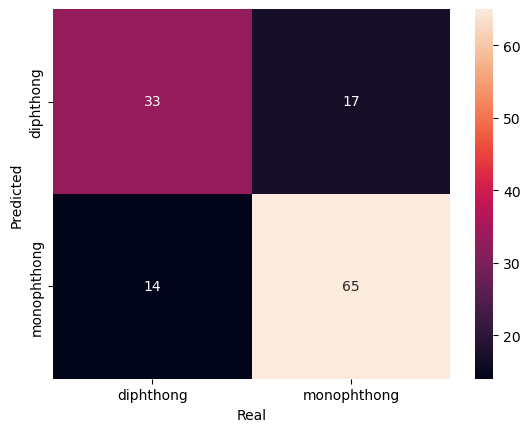

In [34]:
draw_statistics(df, skolt_mono)

## Kildin Saami

In [35]:
df = make_df_cpts('kld', 3)

In [36]:
kld_mono = ['e', 'iː', 'aː', 'eː']

print(f'Overall number of monophthongs is {sum(df.vowel.isin(kld_mono))}\n'\
      f'Overall number of diphthongs is {sum(~df.vowel.isin(kld_mono))}')

Overall number of monophthongs is 149
Overall number of diphthongs is 120


In [37]:
x = df[df.vowel.isin(kld_mono)].f1
y = df[~df.vowel.isin(kld_mono)].f1

obs = np.array([[sum(x == 1), sum(y == 1)], [sum(x > 1), sum(y > 1)]])
res = chi2_contingency(obs)
res

(1.93514077313131,
 0.16419711411550453,
 1,
 array([[99.14869888, 79.85130112],
        [49.85130112, 40.14869888]]))

         mean_1     n
vowel                
aː     1.246753  77.0
ea     1.250000  28.0
eː     1.343750  32.0
iː     1.350000  40.0
ie     1.423913  92.0
0.5440156599552572 0.7046979865771812 0.38333333333333336


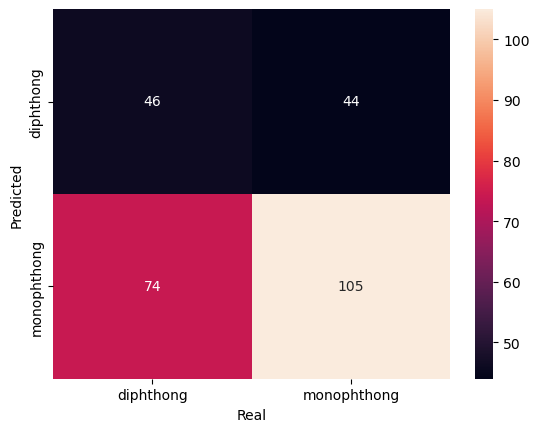

In [38]:
draw_statistics(df, kld_mono, 1)

In [39]:
df = make_df_track_length('kld', 3)

           mean_1     n
vowel                  
iː     127.245000  40.0
eː     198.918750  32.0
ie     295.946739  92.0
aː     299.336364  77.0
ea     516.210714  28.0
Threshold is set to 287.5315134105025
0.5673937360178971 0.7181208053691275 0.4166666666666667


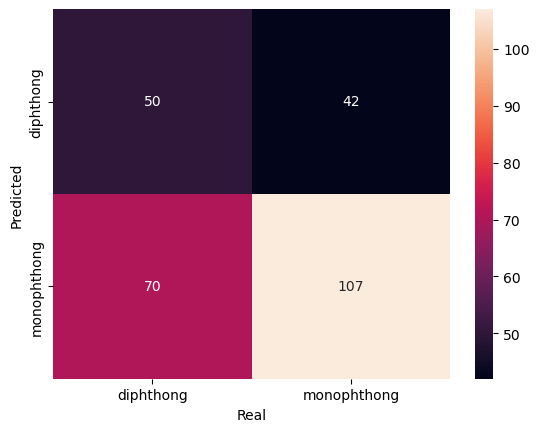

In [40]:
draw_statistics(df, kld_mono)